In [ ]:
!pip install keras_tuner

In [ ]:
# Dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# File paths and Tensorflow
import os
import tensorflow as tf

# Sklearn scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Random forest model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# from tensorflow.keras
import sklearn as skl

# from tensorflow import keras
import keras_tuner as kt
from sklearn.datasets import make_circles


In [ ]:
# Read in the liver_clean.csv
liver_df = pd.read_csv("/content/liver_clean.csv")
liver_df

,Unnamed: 0,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.000000,4.04,227.000000,598.000000,52.700000,57.000000,256.0,9.9,1
1,1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.000000,3.93,22.000000,663.000000,45.000000,75.000000,220.0,10.8,2
2,2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.000000,3.54,51.000000,1243.000000,122.450000,80.000000,225.0,10.0,2
3,3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.000000,3.74,23.000000,1024.000000,77.500000,58.000000,151.0,10.2,2
4,4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.000000,3.54,74.000000,1052.000000,108.500000,109.000000,151.0,11.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9634,24963,3577,C,Placebo,17897,F,Y,N,Y,N,0.7,369.510563,3.49,97.648387,1982.655769,122.556346,124.702128,243.0,9.7,1
9635,24971,4795,C,Placebo,23376,F,Y,N,Y,N,1.8,369.510563,3.24,97.648387,1982.655769,122.556346,124.702128,139.0,10.5,1
9636,24972,3358,D,D-penicillamine,24585,F,N,Y,N,N,2.1,262.000000,3.48,58.000000,2045.000000,89.900000,84.000000,412.0,11.8,3
9637,24991,4365,C,D-penicillamine,21324,F,N,N,N,N,0.9,346.000000,3.40,81.000000,1098.000000,122.450000,90.000000,228.0,10.3,2


In [ ]:
#drop the "unnamed: 0" uneccesary index column
liver_clean_df=liver_df.drop(columns=["Unnamed: 0"])

liver_clean_df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


In [ ]:
liver_clean_df['Stage']

0       1
1       2
2       2
3       2
4       1
       ..
9634    1
9635    1
9636    3
9637    2
9638    3
Name: Stage, Length: 9639, dtype: int64

In [ ]:
# Generate categorical variable lists
liver_clean_cat = liver_clean_df.dtypes[liver_clean_df.dtypes == "object"].index.tolist()

In [ ]:
#Print liver_clean_cat list
print(liver_clean_cat)

['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


In [ ]:
# Check number of unique values in each column
liver_clean_df[liver_clean_cat].nunique()

Status          3
Drug            2
Sex             2
Ascites         2
Hepatomegaly    2
Spiders         2
Edema           3
dtype: int64

In [ ]:
# Create OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform OneHotEncoder using categorical variable list
# Result is stored in new DataFrame called encode_df
encode_df = pd.DataFrame(enc.fit_transform(liver_clean_df[liver_clean_cat]))

# Add encoded variable names to encode_df dataframe
# Assign encoded variable names to columns of encode_df DataFrame
# get_feature_names_out method retrieves feature names for encoded categorical variables
encode_df.columns = enc.get_feature_names_out(liver_clean_cat)

#print
encode_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Status_C,Status_CL,Status_D,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
#Get liver_clean_df column names into list form
liver_list = liver_clean_df.columns.tolist()
print(liver_list)

['N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']


In [ ]:
#Get encode_df column names into list form
column_list = encode_df.columns.tolist()
print(column_list)

['Status_C', 'Status_CL', 'Status_D', 'Drug_D-penicillamine', 'Drug_Placebo', 'Sex_F', 'Sex_M', 'Ascites_N', 'Ascites_Y', 'Hepatomegaly_N', 'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y', 'Edema_N', 'Edema_S', 'Edema_Y']


In [ ]:
#Merge one-hot encoded features and drop original features

#Merge encoded features, encode_df, with original dataframe, liver_clean_df, into liver_clean_df
#left_index=True and right_index=True parameters indicate that merge is based on index of DataFrames
liver_clean_df = liver_clean_df.merge(encode_df, left_index=True, right_index=True)

#Drop original categorical columns, collected in liver_lean_cat, from liver_clean_df
#axis=1 parameter specifies columns (not rows) should be dropped
liver_clean_df = liver_clean_df.drop(liver_clean_cat, axis=1)

liver_clean_df.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,2221,18499,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,1230,19724,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,4184,11839,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,2090,16467,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2105,21699,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
# Get number of columns (features)
num_features = liver_clean_df.shape[1]
print("Number of features in the DataFrame:", num_features)

Number of features in the DataFrame: 28


In [ ]:
#Define X and y
X=liver_clean_df.drop(["Stage"],axis=1)
y=liver_clean_df[["Stage"]]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [ ]:
# Split preprocessed data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.2, random_state=78)

In [ ]:
# Create StandardScaler instances
scaler = StandardScaler()

# Fit StandardScaler
X_scaler = scaler.fit(X_train)

# Scale data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
print(X_train_scaled)

[[ 1.47478759  1.91977093 -0.58030606 ...  0.44623851 -0.39140986
  -0.18534615]
 [-0.54840842  1.50485971  0.74594393 ...  0.44623851 -0.39140986
  -0.18534615]
 [-0.85620447 -0.37584224  1.71852725 ...  0.44623851 -0.39140986
  -0.18534615]
 ...
 [ 0.46882    -0.01137535  0.61331893 ...  0.44623851 -0.39140986
  -0.18534615]
 [ 0.78318487 -0.89745246  0.54700643 ...  0.44623851 -0.39140986
  -0.18534615]
 [ 0.9014236   0.12939338 -0.44768106 ...  0.44623851 -0.39140986
  -0.18534615]]


In [ ]:
print(X_test_scaled)

[[ 2.46104872 -0.93178629 -0.5582019  ...  0.44623851 -0.39140986
  -0.18534615]
 [-1.19684462  0.25537215 -0.27084773 ... -2.24095404  2.55486668
  -0.18534615]
 [ 1.27396943 -0.16350066  0.01650643 ...  0.44623851 -0.39140986
  -0.18534615]
 ...
 [ 2.01343068  1.80567694 -0.6245144  ...  0.44623851 -0.39140986
  -0.18534615]
 [ 1.03561517 -1.13224308 -0.46978523 ...  0.44623851 -0.39140986
  -0.18534615]
 [ 0.12724145 -1.51176403 -0.5582019  ...  0.44623851 -0.39140986
  -0.18534615]]


In [ ]:
#Verify type of X_train_scaled to ensure it is list or array
print(type(X_train_scaled))

<class 'numpy.ndarray'>


In [ ]:
#Verify type of X_test_scaled to ensure it is list or array
print(type(X_test_scaled))

<class 'numpy.ndarray'>


Model Optimization Process

In [ ]:
#separate the features from the target variable (Stage)
# y = liver_df['Stage']

# X = liver_df.drop(["Unnamed: 0", "Stage"], axis=1)

# One-hot encode the target variable y_train
encoder = OneHotEncoder(sparse=False)

# Convert DataFrame to numpy array before reshaping
y_array = y.to_numpy()

# One-hot encode the target variable y_train
y_encoded = encoder.fit_transform(y_array.reshape(-1, 1))

# Compile the model
nn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
#overview of some of the categorical columns: if only Y & N as options, can convert to "1" and "0"
# print(X["Spiders"].value_counts())
# print(X["Ascites"].value_counts())
# print(X["Hepatomegaly"].value_counts())
# print(X["Edema"].value_counts())

In [ ]:
#Edema has "S" as a third option, will convert to numerical with "get dummies" later on
#replace categorical values in Ascites, Hepatomegaly, Spiders columns with numerical values: {"Y": 1, "N": 0}
# X[["Ascites", "Hepatomegaly", "Spiders"]] = X[["Ascites", "Hepatomegaly", "Spiders"]].replace({"Y": 1, "N": 0}).astype(int)

# #preview features data
# X.head()

In [ ]:
# Encode the remaining categorical variables (Status, Drug) using get_dummies
X = pd.get_dummies(X, dtype=int)

#preview dataset with categorical data converted
X.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,2221,18499,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,...,0,1,0,0,1,1,0,1,0,0
1,1230,19724,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,...,1,0,1,1,0,0,1,1,0,0
2,4184,11839,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,...,0,1,0,1,0,1,0,1,0,0
3,2090,16467,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,...,0,1,0,1,0,1,0,1,0,0
4,2105,21699,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,...,0,1,0,0,1,1,0,1,0,0


In [ ]:
# y = liver_df['Stage']
# X = liver_df.drop(columns=['Stage'])
# plt.hist(X,y)
# plt.xlabel('Stage')
# plt.ylabel('Number of Months')
# plt.title("Number of Months for Various Liver Cirrhosis Stages")
# plt.show()

In [ ]:
# Use sklearn to split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=78)

# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train_scaled)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
print(X_train_scaled)
print(X_test_scaled)

[[ 1.34900000e+03  1.20350000e+04  2.20000000e+00 ...  1.00000000e+00
  -4.24039515e-17  1.84365007e-17]
 [ 1.82700000e+03  2.48030000e+04  8.40000000e+00 ...  1.00000000e+00
  -4.24039515e-17  1.84365007e-17]
 [ 2.84700000e+03  1.86280000e+04  1.20000000e+00 ...  1.00000000e+00
  -4.24039515e-17  1.84365007e-17]
 ...
 [ 2.38600000e+03  1.84600000e+04  6.00000000e+00 ...  1.00000000e+00
  -4.24039515e-17  1.84365007e-17]
 [ 2.72100000e+03  1.51050000e+04  5.70000000e+00 ...  1.00000000e+00
  -4.24039515e-17  1.84365007e-17]
 [ 2.84700000e+03  1.89930000e+04  1.20000000e+00 ...  1.00000000e+00
  -4.24039515e-17  1.84365007e-17]]
[[ 4.50900000e+03  1.49750000e+04  7.00000000e-01 ...  1.00000000e+00
  -4.24039515e-17  1.84365007e-17]
 [ 6.11000000e+02  1.94700000e+04  2.00000000e+00 ... -4.97785518e-17
   1.00000000e+00  1.84365007e-17]
 [ 3.24400000e+03  1.78840000e+04  3.30000000e+00 ...  1.00000000e+00
  -4.24039515e-17  1.84365007e-17]
 ...
 [ 1.14100000e+03  1.53410000e+04  2.5000000

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
# Define the function to create the model
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow KerasTuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    # Allow KerasTuner to decide the number of neurons in the first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
      min_value=1,
      max_value=50,
      step=5),
      activation=activation,
      input_dim=27))

    # Allow KerasTuner to decide the number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
      nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
      min_value=1,
      max_value=50,
      step=5),
      activation=activation))
    nn_model.add(tf.keras.layers.Dense(units=3, activation="softmax"))
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    return nn_model



In [ ]:
# Create the tuner
tuner = kt.Hyperband(create_model,
objective='val_accuracy',
max_epochs=100,
hyperband_iterations=2,
overwrite = True)

In [ ]:
# Search for the best hyperparameters
tuner.search(X_train_scaled, y_train, epochs=100, validation_data=(X_test_scaled, y_test))


Trial 508 Complete [00h 01m 26s]
val_accuracy: 0.35062241554260254

Best val_accuracy So Far: 0.5485477447509766
Total elapsed time: 01h 40m 20s


In [ ]:
# Evaluate the optimized model
# Calculate the confusion matrix

o_model =
o_matrix = confusion_matrix(y_test,)

In [ ]:
#  Heatmap for variables' correlation:
import seaborn as sns

correlation_metrics = liver_clean_df.corr()

# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_metrics, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Summarized Correlation Heatmap')
plt.show()

In [ ]:
# Logistic Regression Model

In [ ]:
-DNU-
# # Initialize the OneHotEncoder
# enc = OneHotEncoder(sparse=False)

# # Reshape the target variable
# Y = liver_clean_df['Stage'].values.reshape(-1, 1)

# # Fit and transform the target variable
# Y_encoded = enc.fit_transform(Y)

# # Convert the encoded target variable to a DataFrame
# Y_encoded_df = pd.DataFrame(Y_encoded, columns=enc.get_feature_names_out(['Stage']))
# # Y_encoded_df = pd.DataFrame(Y_encoded, columns=enc.get_feature_names(['Stage']))


# # Drop the original 'Stage' column and concatenate the encoded 'Stage' columns
# liver_y_clean_df = liver_clean_df.drop('Stage', axis=1)

# # Concatenate the DataFrames along the columns axis
# liver_y_clean_df = pd.concat([liver_y_clean_df.reset_index(drop=True), Y_encoded_df], axis=1)

# # Print the updated DataFrame
# print(liver_y_clean_df.head())

# PCA Optimization

In [ ]:
# Import the PCA model and other dependencies
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [ ]:
# Preview the df
liver_clean_df

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,2221,18499,0.5,149.000000,4.04,227.000000,598.000000,52.700000,57.000000,256.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,1230,19724,0.5,219.000000,3.93,22.000000,663.000000,45.000000,75.000000,220.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,4184,11839,0.5,320.000000,3.54,51.000000,1243.000000,122.450000,80.000000,225.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,2090,16467,0.7,255.000000,3.74,23.000000,1024.000000,77.500000,58.000000,151.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2105,21699,1.9,486.000000,3.54,74.000000,1052.000000,108.500000,109.000000,151.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9634,3577,17897,0.7,369.510563,3.49,97.648387,1982.655769,122.556346,124.702128,243.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
9635,4795,23376,1.8,369.510563,3.24,97.648387,1982.655769,122.556346,124.702128,139.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
9636,3358,24585,2.1,262.000000,3.48,58.000000,2045.000000,89.900000,84.000000,412.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
9637,4365,21324,0.9,346.000000,3.40,81.000000,1098.000000,122.450000,90.000000,228.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
# Check columns
# We want to take out the 'Stage' column for the PCA since it is the target/dependent variable. This will leave us with everything else, which are the feature/independent variables
liver_clean_df.columns

Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status_C', 'Status_CL', 'Status_D', 'Drug_D-penicillamine',
       'Drug_Placebo', 'Sex_F', 'Sex_M', 'Ascites_N', 'Ascites_Y',
       'Hepatomegaly_N', 'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y', 'Edema_N',
       'Edema_S', 'Edema_Y'],
      dtype='object')

In [ ]:
# Drop the 'Stage' column. PCA only needs the independent variables
liver_clean_df_preprocess = liver_clean_df.drop(columns=['Stage'])

# Recheck columns to make sure 'Stage' dropped
liver_clean_df_preprocess.columns

Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Status_C', 'Status_CL', 'Status_D', 'Drug_D-penicillamine',
       'Drug_Placebo', 'Sex_F', 'Sex_M', 'Ascites_N', 'Ascites_Y',
       'Hepatomegaly_N', 'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y', 'Edema_N',
       'Edema_S', 'Edema_Y'],
      dtype='object')

In [ ]:
# Scale the data
liver_clean_std_df = StandardScaler().fit_transform(liver_clean_df_preprocess)
liver_clean_std_df

array([[ 0.28349281,  0.0187566 , -0.60473075, ...,  0.44345016,
        -0.38192022, -0.19611614],
       [-0.62271874,  0.35039685, -0.60473075, ...,  0.44345016,
        -0.38192022, -0.19611614],
       [ 2.07854151, -1.78428346, -0.60473075, ...,  0.44345016,
        -0.38192022, -0.19611614],
       ...,
       [ 1.32321282,  1.6663995 , -0.25012424, ...,  0.44345016,
        -0.38192022, -0.19611614],
       [ 2.24405543,  0.78355962, -0.51607912, ...,  0.44345016,
        -0.38192022, -0.19611614],
       [-1.11285939,  2.76690368, -0.53824203, ...,  0.44345016,
        -0.38192022, -0.19611614]])

In [ ]:
# Create a PCA model instance with n_components = 3
pca = PCA(n_components = 3)

In [ ]:
# Fit the PCA model on the liver_clean_df
liver_clean_pca = pca.fit_transform(liver_clean_std_df)

# View first 5 rows of the list data
liver_clean_pca[:5]

array([[-2.16440734, -0.23215601, -0.44419682],
       [ 0.63931183, -3.00691513,  4.39036448],
       [-2.38904915, -1.74935287, -0.62932148],
       [-1.25575587, -0.60091572, -0.39772625],
       [-0.44369955,  1.57006952, -0.41931353]])

In [ ]:
# Calculate the explained variance and total explained variance
explained_var = pca.explained_variance_ratio_

total_explained_var = np.cumsum(explained_var)
print(f"Explained Variance: {explained_var}")
print(f"Total Explained Variance: {total_explained_var}")

Explained Variance: [0.16107849 0.14654824 0.07651134]
Total Explained Variance: [0.16107849 0.30762674 0.38413808]


In [ ]:
# Create the PCA df
liver_pca_df = pd.DataFrame(
    liver_clean_pca,
    columns=["PCA1", "PCA2", "PCA3"]
)

# Preview the df
liver_pca_df.head()

,PCA1,PCA2,PCA3
0,-2.164407,-0.232156,-0.444197
1,0.639312,-3.006915,4.390364
2,-2.389049,-1.749353,-0.629321
3,-1.255756,-0.600916,-0.397726
4,-0.443700,1.570070,-0.419314


### PCA Dataframe into elbow method

In [ ]:
# Suppress the warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Create list to store inertia values and values of k
inertia = []
k = list(range(1, 11))

# Append the value of computer inertia from 'inertia_' attribute of the KMeans model instance
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(liver_pca_df)
    inertia.append(km.inertia_)

# Define a df to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
elbow_df = pd.DataFrame(elbow_data)

elbow_df.head(10)


,k,inertia
0,1,99973.086583
1,2,65867.753031
2,3,45557.503984
3,4,33228.179331
4,5,27234.082379
5,6,22787.392210
6,7,18968.666569
7,8,16942.611715
8,9,15064.059709
9,10,13637.870899


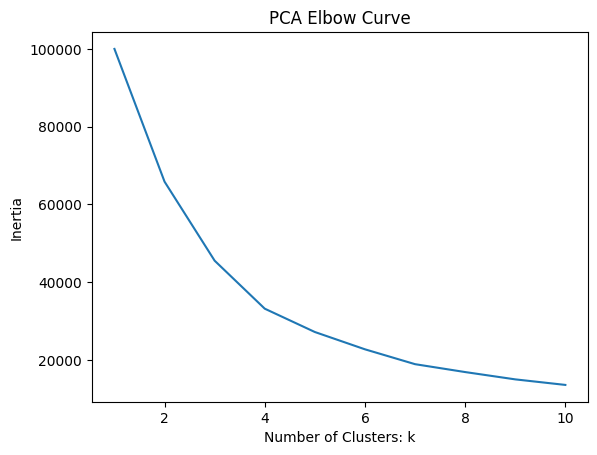

The elbow curve shows that the best k-value is 4.


In [ ]:
# Plot the elbow curve using pyplot
plt.plot(elbow_df['k'], elbow_df["inertia"])
plt.xlabel("Number of Clusters: k")
plt.ylabel("Inertia")
plt.title("PCA Elbow Curve")
plt.show()

print(f"The elbow curve shows that the best k-value is 4.")

### K-means with PCA Data

### 1. Try with k = 4.

In [ ]:
# Initialize the K-means model with k=4 (based on the plot above)
model = KMeans(n_clusters=4, random_state=0)

# Fit the model to the PCA
model.fit(liver_pca_df)


KMeans(n_clusters=4, random_state=0)

In [ ]:
# Predict the clusters
predictions = model.predict(liver_pca_df)

# Print the predictions
print(predictions)

[1 2 1 ... 1 1 2]


In [ ]:
# Create copy of PCA df
pca_df_predictions = liver_pca_df.copy()

# Add a column to the new df with the predicted clusters
pca_df_predictions['pca_clusters'] = predictions

# Preview the df
pca_df_predictions.head()

,PCA1,PCA2,PCA3,pca_clusters
0,-2.164407,-0.232156,-0.444197,1
1,0.639312,-3.006915,4.390364,2
2,-2.389049,-1.749353,-0.629321,1
3,-1.255756,-0.600916,-0.397726,1
4,-0.443700,1.570070,-0.419314,3


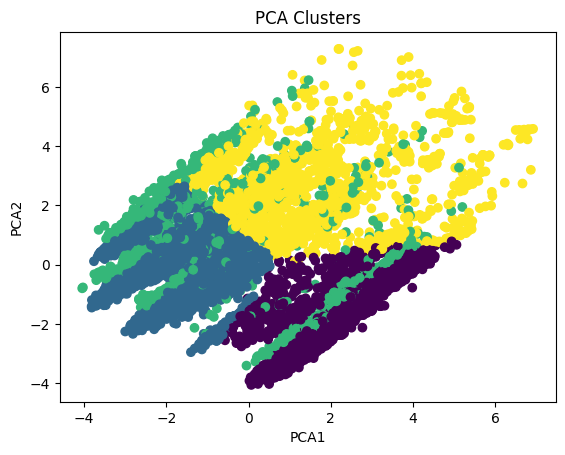

In [ ]:
# Scatter plot of the predicted clusters
plt.scatter(pca_df_predictions['PCA1'], pca_df_predictions['PCA2'], c=pca_df_predictions['pca_clusters'])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA Clusters')
plt.show()

### 2. Try with k = 3

In [ ]:
# Initialize the K-means model with k=3
model = KMeans(n_clusters=3, random_state=0)

# Fit the model to the PCA
model.fit(liver_pca_df)

KMeans(n_clusters=3, random_state=0)

In [ ]:
# Predict the clusters
predictions = model.predict(liver_pca_df)

# Print the predictions
print(predictions)

[0 2 0 ... 0 0 1]


In [ ]:
# Create copy of PCA df
pca_df_predictions = liver_pca_df.copy()

# Add a column to the new df with the predicted clusters
pca_df_predictions['pca_clusters'] = predictions

# Preview the df
pca_df_predictions.head()

,PCA1,PCA2,PCA3,pca_clusters
0,-2.164407,-0.232156,-0.444197,0
1,0.639312,-3.006915,4.390364,2
2,-2.389049,-1.749353,-0.629321,0
3,-1.255756,-0.600916,-0.397726,0
4,-0.443700,1.570070,-0.419314,1


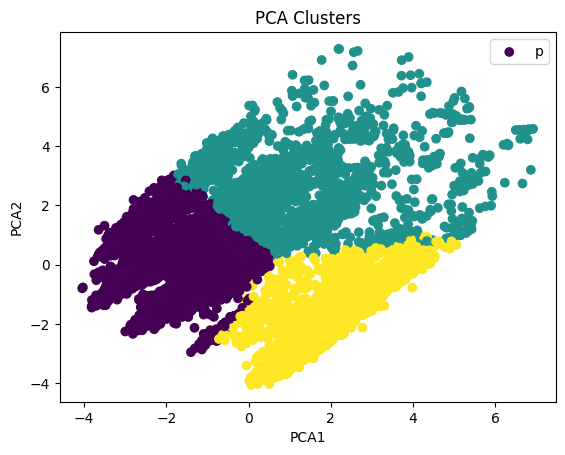

In [ ]:
# Scatter plot of the predicted clusters
plt.scatter(pca_df_predictions['PCA1'], pca_df_predictions['PCA2'], c=pca_df_predictions['pca_clusters'])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA Clusters')
plt.legend('pca_clusters')
plt.show()

Using k = 3 seems to make the most sense in this case, especially with knowing that there are only 3 target outputs (i.e. Stages 1, 2, or 3). Using 4 clusters caused some overlap in the clusters, whereas using 3 clusters gave more distinct groupings.